In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.test_util import check_grads

import paragami
import scipy as osp

import copy
import example_utils

import matplotlib.pyplot as plt
%matplotlib inline
def comparison_plot(x, y):
    plt.plot(x, x, 'k')
    plt.plot(x, y, 'r+')

In [2]:
np.random.seed(42)

num_obs = 20

# True values of parameters
true_sigma = \
    np.eye(3) * np.diag(np.array([1, 2, 3])) + \
    np.random.random((3, 3)) * 0.1
true_sigma = 0.5 * (true_sigma + true_sigma.T)

true_mu = np.array([0, 1, 2])

# Data
x = np.random.multivariate_normal(
    mean=true_mu, cov=true_sigma, size=(num_obs, ))

# Original weights.
original_weights = np.ones(num_obs)

# Original regularizer.
original_lam = 1.0

In [3]:
def model_logpdf(norm_par, weights, x):
    data_lpdf = example_utils.get_normal_log_prob(
        x, mu=norm_par['mu'], sigma=norm_par['sigma'])
    return np.sum(weights * data_lpdf)

def objective_fun(norm_par, weights, lam, x):
    return \
        -model_logpdf(norm_par, weights, x) + \
        example_utils.regularizer(norm_par, lam)

norm_par = dict()
norm_par['mu'] = true_mu
norm_par['sigma'] = true_sigma

objective_fun(norm_par, original_weights, original_lam, x)

54.865233212052416

In [4]:
norm_param_pattern = paragami.PatternDict()
norm_param_pattern['sigma'] = paragami.PSDSymmetricMatrixPattern(size=3)
norm_param_pattern['mu'] = paragami.NumericArrayPattern(shape=(3, ))

objective_flat = paragami.FlattenFunctionInput(
    lambda par_dict: objective_fun(par_dict, original_weights, original_lam, x),
    patterns=norm_param_pattern,
    free=True)

# It's always a good idea to double check for bugs.

# This checks that the two functions return the same value.
norm_par_flat = norm_param_pattern.flatten(norm_par, free=True)
assert(np.linalg.norm(
    objective_flat(norm_par_flat) - \
    objective_fun(norm_par, original_weights, original_lam, x)) < 1e-8)

# This verifies that the objective is being differentiated correctly.
check_grads(objective_flat)(norm_par_flat)

In [5]:
objective_wrapper = paragami.OptimizationObjective(objective_flat)
objective_wrapper.set_print_every(5)

init_param = np.ones(norm_param_pattern.flat_length(free=True))

mle_opt = osp.optimize.minimize(
    method='trust-ncg',
    x0=init_param,
    fun=objective_wrapper.f,
    jac=objective_wrapper.grad,
    hessp=objective_wrapper.hessian_vector_product,
    options={'gtol': 1e-12, 'disp': False})

Iter 0: f = 75.01808914
Iter 5: f = 53.28119655
Iter 10: f = 52.41482181


In [6]:
print(mle_opt.x)
norm_par_opt = norm_param_pattern.fold(mle_opt.x, free=True)
print(norm_par_opt['sigma'])
print(true_sigma)
print(norm_par_opt['mu'])
print(true_mu)

par_flat0 = copy.deepcopy(mle_opt.x)
hess0 = objective_wrapper.hessian(par_flat0)

[ 0.05740087 -0.06722489  0.41448746  0.31809515  0.31187714  0.50879256
  0.06754915  0.56287859  1.5747403 ]
[[ 1.12165104 -0.07119656  0.3368883 ]
 [-0.07119656  2.29548831  0.45067169]
 [ 0.3368883   0.45067169  2.9649578 ]]
[[1.03745401 0.07746864 0.03950388]
 [0.07746864 2.01560186 0.05110853]
 [0.03950388 0.05110853 3.0601115 ]]
[0.06754915 0.56287859 1.5747403 ]
[0 1 2]


In [15]:
lam_free = True # Works better

# To evaluate the regularization parameter
lam_pattern = paragami.NumericScalarPattern(lb=0)
objective_reg_flat = \
    paragami.FlattenFunctionInput(
        lambda par_dict, lam: objective_fun(par_dict, original_weights, lam, x),
    patterns=[norm_param_pattern, lam_pattern],
    free=[True, lam_free])
lam_flat0 = lam_pattern.flatten(original_lam, free=lam_free)

# Sanity check
assert(objective_reg_flat(par_flat0, lam_flat0) ==
       objective_fun(norm_par_opt, original_weights, original_lam, x))

weight_sens = paragami.ParametricSensitivityTaylorExpansion(
    objective_reg_flat,
    input_val0=par_flat0,
    hyper_val0=lam_flat0,
    hess0=hess0,
    order=4)

In [16]:
def reoptimize_lam(lam_flat1, print_every=10):
    new_objective_wrapper = \
        paragami.OptimizationObjective(
            lambda par_flat: objective_reg_flat(par_flat, lam_flat1))
    new_objective_wrapper.set_print_every(10)
    new_mle_opt = osp.optimize.minimize(
        method='trust-ncg',
        x0=par_flat0,
        fun=new_objective_wrapper.f,
        jac=new_objective_wrapper.grad,
        hessp=new_objective_wrapper.hessian_vector_product,
        options={'gtol': 1e-12, 'disp': False})
    return new_mle_opt

dhyper norm 1.6094379124341003
Iter 0: f = 63.61962888
Iter 10: f = 56.85369784
0.4602971498867068
0.16679262183876564
0.349444105472274
0.3396283120702931


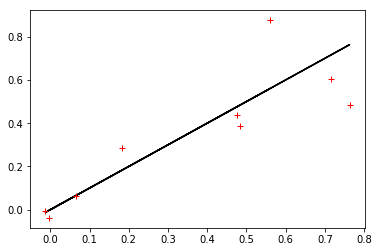

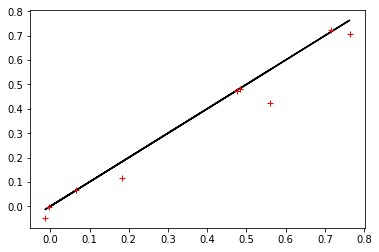

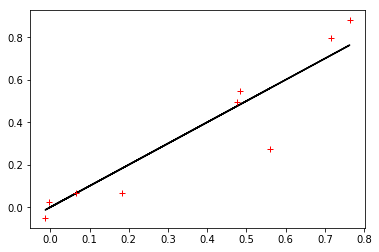

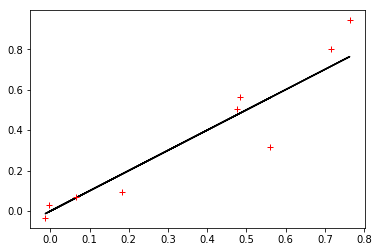

In [20]:
new_lam = 5
#new_lam = 0.001

lam_flat1 = lam_pattern.flatten(new_lam, free=lam_free)
print('dhyper norm', np.linalg.norm(lam_flat1 - lam_flat0))
par1 = reoptimize_lam(lam_flat1).x

plt.figure()
par1_pred = weight_sens.evaluate_taylor_series(lam_flat1, max_order=1)
comparison_plot(par1, par1_pred)
print(np.linalg.norm(par1 - par1_pred))

plt.figure()
par1_pred = weight_sens.evaluate_taylor_series(lam_flat1, max_order=2)
comparison_plot(par1, par1_pred)
print(np.linalg.norm(par1 - par1_pred))

plt.figure()
par1_pred = weight_sens.evaluate_taylor_series(lam_flat1, max_order=3)
comparison_plot(par1, par1_pred)
print(np.linalg.norm(par1 - par1_pred))

plt.figure()
par1_pred = weight_sens.evaluate_taylor_series(lam_flat1, max_order=4)
comparison_plot(par1, par1_pred)
print(np.linalg.norm(par1 - par1_pred))


In [21]:
# To evaluate the regularization parameter
weight_pattern = paragami.NumericVectorPattern(length=num_obs)
objective_weight_flat = \
    paragami.FlattenFunctionInput(
        lambda par_dict, weights: objective_fun(par_dict, weights, original_lam, x),
    patterns=[norm_param_pattern, weight_pattern],
    free=[True, False])
weight_flat0 = weight_pattern.flatten(original_weights, free=False)

# Sanity check
assert(objective_weight_flat(par_flat0, weight_flat0) ==
       objective_fun(norm_par_opt, original_weights, original_lam, x))

weight_sens = paragami.ParametricSensitivityTaylorExpansion(
    objective_weight_flat,
    input_val0=par_flat0,
    hyper_val0=weight_flat0,
    hess0=hess0,
    order=4)

In [22]:
def reoptimize_weights(weight_flat1, print_every=10):
    new_objective_wrapper = \
        paragami.OptimizationObjective(
            lambda par_flat: objective_weight_flat(par_flat, weight_flat1))
    new_objective_wrapper.set_print_every(10)
    new_mle_opt = osp.optimize.minimize(
        method='trust-ncg',
        x0=par_flat0,
        fun=new_objective_wrapper.f,
        jac=new_objective_wrapper.grad,
        hessp=new_objective_wrapper.hessian_vector_product,
        options={'gtol': 1e-12, 'disp': False})
    return new_mle_opt

dhyper norm 4.47213595499958
Iter 0: f = 52.31671520
Iter 10: f = 49.25202448
0.18013122953215177
0.04244928646207848
0.02190827086130712
0.004876757824705567


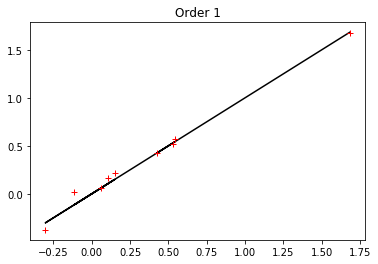

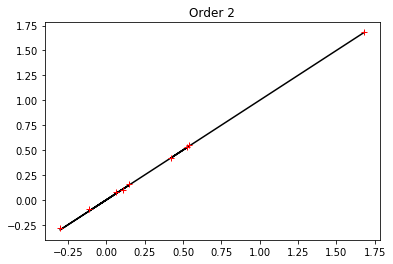

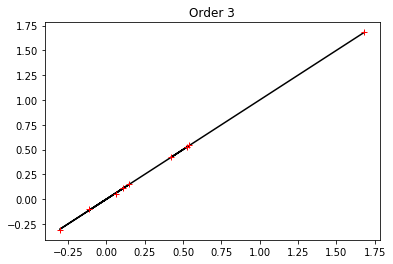

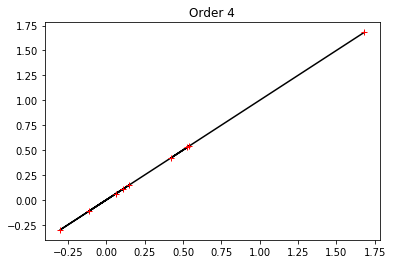

In [24]:
new_weights = example_utils.draw_bootstrap_weights(num_obs)
weight_flat1 = weight_pattern.flatten(new_weights, free=False)

print('dhyper norm', np.linalg.norm(weight_flat1 - weight_flat0))
par1 = reoptimize_weights(weight_flat1).x

for order in range(1, 5):
    plt.figure()
    plt.title('Order {}'.format(order))
    par1_pred = weight_sens.evaluate_taylor_series(weight_flat1, max_order=order)
    comparison_plot(par1, par1_pred)
    print(np.linalg.norm(par1 - par1_pred))
